# Notebook 2: Payday Analysis

**Objective:**  
Understand baseline sales patterns and examine payday effects (15th and end of month).

**Outputs:**  
- Tables in `results/tables/`  
- Figures in `results/figures/`  
- Analysis-ready data in `data/processed/analysis_ready.parquet`  


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")


## 1. Load data and prepare features


In [7]:
NB_DIR = Path.cwd()
PROJ_DIR = NB_DIR.parent
TABLES_DIR = PROJ_DIR / "results" / "tables"
PROC_DIR = PROJ_DIR / "data" / "processed"
ANALYSIS_FP = PROC_DIR / "analysis_ready.parquet"

if ANALYSIS_FP.exists():
    df = pd.read_parquet(ANALYSIS_FP)
else:
    df = pd.read_parquet(PROC_DIR / "train_clean_parquet")
    df = df.rename(columns={"unit_sales": "sales"})
    df["date"] = pd.to_datetime(df["date"])
    df["is_payday"] = df["date"].dt.is_month_end | df["date"].dt.day.eq(15)
    df["dow"] = df["date"].dt.day_name()
    df["month"] = df["date"].dt.month

    # add family if missing
    items_fp = PROC_DIR / "items.parquet"
    if "family" not in df and items_fp.exists():
        items = pd.read_parquet(items_fp)
        df = df.merge(items[["item_nbr", "family"]].drop_duplicates(),
                      on="item_nbr", how="left")

    cols = [c for c in ["date","store_nbr","family","sales","is_payday","dow","month"] if c in df]
    df[cols].to_parquet(ANALYSIS_FP, index=False)

TABLES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Rows: {len(df):,}")
print(f"Period: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Stores: {df['store_nbr'].nunique()}, Families: {df['family'].nunique() if 'family' in df else 'NA'}")


Rows: 125,497,040
Period: 2013-01-01 → 2017-08-15
Stores: 54, Families: 33


In [8]:
print("Payday vs non-payday day counts:")
print(df.groupby("is_payday")["date"].nunique())

print("\nSales summary stats:")
print(df["sales"].describe())


Payday vs non-payday day counts:
is_payday
False    1573
True      111
Name: date, dtype: int64

Sales summary stats:
count    1.254970e+08
mean     8.554866e+00
std      2.360515e+01
min     -1.537200e+04
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: sales, dtype: float64


## 2. Overall payday effect


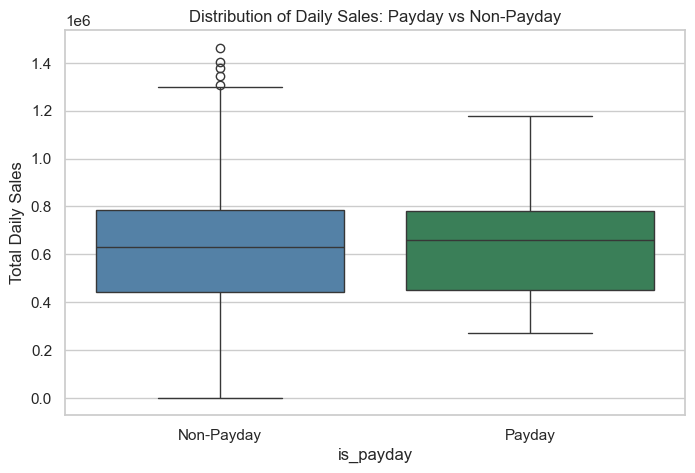

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="is_payday", y="sales", hue="is_payday", data=daily,
            palette=["steelblue","seagreen"], legend=False)
plt.xticks([0,1], ["Non-Payday", "Payday"])
plt.title("Distribution of Daily Sales: Payday vs Non-Payday")
plt.ylabel("Total Daily Sales")
plt.show()

## 3. Payday effect by store


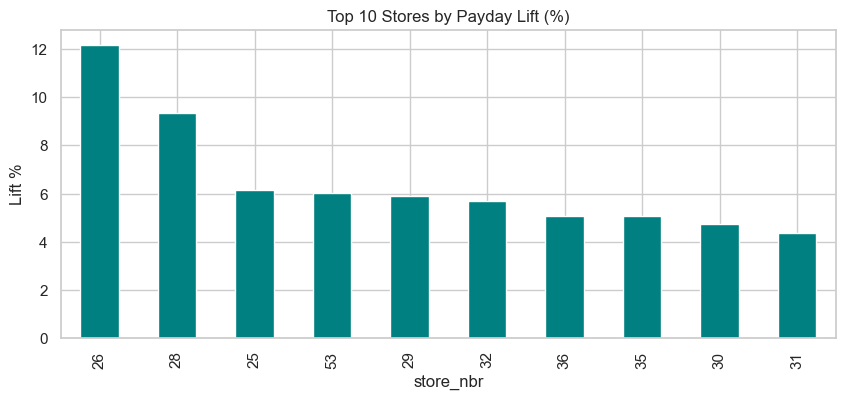

In [10]:
by_store = (
    df.groupby(["store_nbr", "is_payday"])["sales"]
      .mean()
      .unstack(fill_value=0)
)
by_store["lift_pct"] = 100 * (by_store[True] / by_store[False] - 1)
by_store.to_csv(TABLES_DIR / "payday_lift_by_store.csv")

top_stores = by_store.sort_values("lift_pct", ascending=False).head(10)

top_stores["lift_pct"].plot(kind="bar", figsize=(10,4), color="teal")
plt.title("Top 10 Stores by Payday Lift (%)")
plt.ylabel("Lift %")
plt.show()


## 4. Payday effect by category


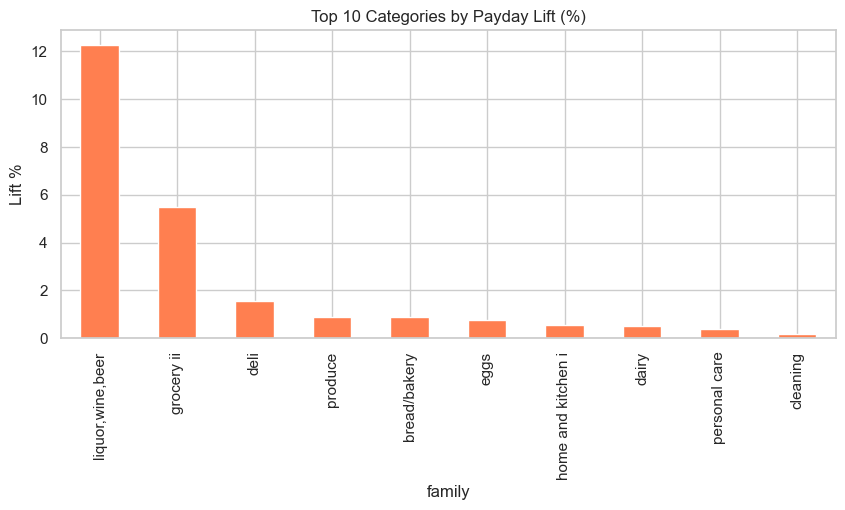

In [11]:
if "family" in df:
    by_cat = (
        df.groupby(["family", "is_payday"])["sales"]
          .mean()
          .unstack(fill_value=0)
    )
    by_cat["lift_pct"] = 100 * (by_cat[True] / by_cat[False] - 1)
    by_cat.to_csv(TABLES_DIR / "payday_lift_by_category.csv")

    top_cats = by_cat.sort_values("lift_pct", ascending=False).head(10)

    top_cats["lift_pct"].plot(kind="bar", figsize=(10,4), color="coral")
    plt.title("Top 10 Categories by Payday Lift (%)")
    plt.ylabel("Lift %")
    plt.show()


## 5. Sales trend over time


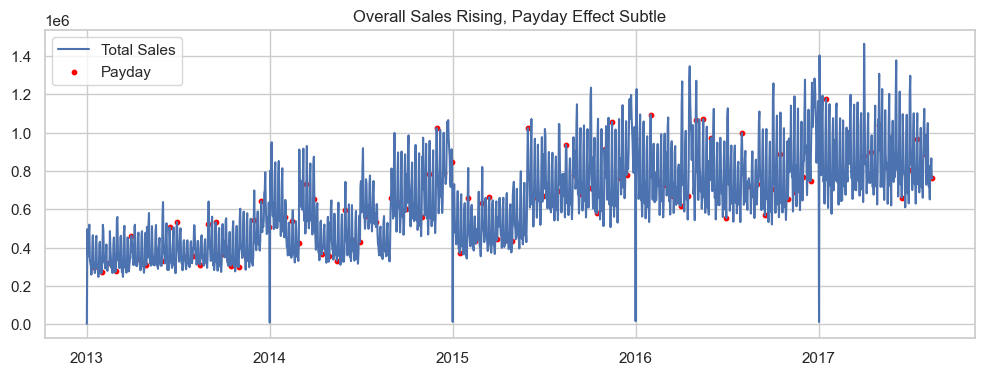

In [20]:
daily_sales = df.groupby("date")["sales"].sum()

plt.figure(figsize=(12,4))
plt.plot(daily_sales.index, daily_sales.values, label="Total Sales")

paydays = daily_sales[daily_sales.index.to_series().dt.is_month_end |
                      (daily_sales.index.to_series().dt.day == 15)]
plt.scatter(paydays.index, paydays.values, color="red", label="Payday", s=10)

plt.title("Overall Sales Rising, Payday Effect Subtle")
plt.legend()
plt.show()


In [13]:
# Calculations
lift_overall = (overall.loc[overall["is_payday"]==True, "avg_sales"].values[0] /
                overall.loc[overall["is_payday"]==False, "avg_sales"].values[0] - 1) * 100

top_store = by_store["lift_pct"].max()
top_cat = by_cat["lift_pct"].max() if "family" in df else None

print(f"Overall payday lift: {lift_overall:.1f}%")
print(f"Max store lift: {top_store:.1f}%")
if top_cat is not None:
    print(f"Max category lift: {top_cat:.1f}%")


Overall payday lift: 0.2%
Max store lift: 12.2%
Max category lift: 12.3%


In [ ]:
# daily total sales with payday flag
daily = df.groupby("date", as_index=False)["sales"].sum()
daily["is_payday"] = daily["date"].dt.is_month_end | daily["date"].dt.day.eq(15)

payday_sales = daily.loc[daily["is_payday"], "sales"]
non_sales = daily.loc[~daily["is_payday"], "sales"]

summary = pd.DataFrame({
    "Mean Sales": [non_sales.mean(), payday_sales.mean()],
    "Std Dev": [non_sales.std(), payday_sales.std()],
    "N Days": [non_sales.count(), payday_sales.count()]
}, index=["Non-Payday", "Payday"])

summary["Lift %"] = (summary["Mean Sales"] / summary.loc["Non-Payday", "Mean Sales"] - 1) * 100
summary.round(2)


,Mean Sales,Std Dev,N Days,Lift %
Non-Payday,636941.0625,235046.81250,1573,0.00
Payday,645964.1875,225765.59375,111,1.42


In [20]:
from scipy import stats

t_stat, p_val = stats.ttest_ind(payday_sales, non_sales, equal_var=False)
print(f"Payday mean = {payday_sales.mean():,.0f}")
print(f"Non-payday mean = {non_sales.mean():,.0f}")
print(f"Lift = {(payday_sales.mean()/non_sales.mean()-1)*100:.1f}%")
print(f"T-test p-value = {p_val:.3g}")


Payday mean = 645,964
Non-payday mean = 636,941
Lift = 1.4%
T-test p-value = 0.686


# Paydays barely move overall sales (+1.4%), but select stores (+12%) and alcohol categories show clear opportunities for targeted promotions.

**Findings:** 

Overall: Average daily sales increase by 1.4%, not statistically significant at the aggregate level.

Stores: Top-performing locations lift by ~12%, while many stores remain unaffected.

Categories: Strongest uplifts occur in Liquor/Wine/Beer, while staples (e.g., dairy, produce) are flat.

**Implications for Strategy:**

Optimize allocation: Increase staffing and stock in high-lift stores during payday periods.

Target promotions: Align discounts and marketing with payday-sensitive categories (alcohol, discretionary goods).

Reduce waste: Avoid over-investing in low-lift categories and stores where paydays show little effect.

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# paths 
ROOT = Path.cwd().parent
PROC = ROOT / "data" / "processed"
RES_FIG = ROOT / "results" / "figures"
RES_TAB = ROOT / "results" / "kpis"
RES_FIG.mkdir(parents=True, exist_ok=True)
RES_TAB.mkdir(parents=True, exist_ok=True)

# load data
df = pd.read_parquet(PROC / "base_with_flags.parquet")
items = pd.read_parquet(PROC / "items.parquet")[["item_nbr", "family"]]
df = df.merge(items, on="item_nbr", how="left")

df["is_payday"] = df["is_payday"].astype(bool)
df["sales"] = pd.to_numeric(df["sales"], errors="coerce").fillna(0.0)

# overall payday lift 
m = df.groupby("is_payday")["sales"].mean()
lift_overall = (m[True] / m[False] - 1) * 100
print(f"Overall payday lift: {lift_overall:.1f}%")

# KPI 2: store-level lift 
store_lift = (
    df.groupby(["store_nbr", "is_payday"])["sales"].mean()
      .unstack(fill_value=0)
      .rename(columns={False: "non_payday", True: "payday"})
)
store_lift["lift_pct"] = (store_lift["payday"] / store_lift["non_payday"] - 1) * 100
store_lift.sort_values("lift_pct", ascending=False).to_csv(RES_TAB / "kpi_store_lift.csv")

print("\nTop stores by lift:")
print(store_lift.sort_values("lift_pct", ascending=False).head(10)[["lift_pct"]].round(1))

plt.figure(figsize=(10,5))
store_lift.sort_values("lift_pct", ascending=False).head(15)["lift_pct"].plot(kind="bar")
plt.title("Store payday lift (%) – top 15")
plt.ylabel("lift %")
plt.tight_layout()
plt.savefig(RES_FIG / "store_lift_top15.png")
plt.close()

# KPI 3: category-level lift
cat_lift = (
    df.groupby(["family", "is_payday"])["sales"].mean()
      .unstack(fill_value=0)
      .rename(columns={False: "non_payday", True: "payday"})
)
cat_lift["lift_pct"] = (cat_lift["payday"] / cat_lift["non_payday"] - 1) * 100
cat_lift.sort_values("lift_pct", ascending=False).to_csv(RES_TAB / "kpi_category_lift.csv")

print("\nTop categories by lift:")
print(cat_lift.sort_values("lift_pct", ascending=False).head(10)[["lift_pct"]].round(1))

plt.figure(figsize=(10,5))
cat_lift.sort_values("lift_pct", ascending=False).head(15)["lift_pct"].plot(kind="bar")
plt.title("Category payday lift (%) – top 15")
plt.ylabel("lift %")
plt.tight_layout()
plt.savefig(RES_FIG / "category_lift_top15.png")
plt.close()


Overall payday lift: 0.2%

Top stores by lift:
is_payday  lift_pct
store_nbr          
26             12.2
28              9.3
25              6.1
53              6.0
29              5.9
32              5.7
36              5.1
35              5.0
30              4.7
31              4.4

Top categories by lift:
is_payday           lift_pct
family                      
liquor,wine,beer        12.3
grocery ii               5.5
deli                     1.5
produce                  0.9
bread/bakery             0.9
eggs                     0.8
home and kitchen i       0.5
dairy                    0.5
personal care            0.4
cleaning                 0.2
